# Amazon Food Reviews - Classifier

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
json_import = drive.CreateFile({'id':'1KpQKJnoX3XCpyW788srGxtO3nwZFJ4oE'})
json_import.GetContentFile('database.sqlite')
json_import = drive.CreateFile({'id':'1XRPgjWYDhIllbS4VWLGDIJ8-pcP7A_r4'})
json_import.GetContentFile('final.sqlite')

The system cannot find the path specified.


ModuleNotFoundError: No module named 'google.colab'

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 


In [5]:
filtered_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [0]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
# def partition(x):
#     if x < 3:
#         return 'negative'
#     return 'positive'
def give_scores(score):
  score = np.asarray(score)
  score = np.where(score == 'positive', 1, 0)
  return score

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
# positiveNegative = actualScore.map(partition) 
positiveNegative = give_scores(actualScore)
filtered_data['Score'] = positiveNegative

In [7]:
filtered_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.


In [9]:
# find sentences containing HTML tags
# i=0;
# for sent in final['Text'].values:
#     if (len(re.findall('<.*?>', sent))):
# #         print(i)
# #         print(sent)
#         break
#     i += 1

stop = set(stopwords.words('english')) #set of stopwords
print(len(stop))
stop.remove('not')
print(len(stop))


179
178


In [0]:
stop = set(stopwords.words('english')) #set of stopwords
stop.remove('not')
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: #'positive': 
                        all_positive_words.append(s)    #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:  #'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [0]:

# store final table into an SQlLite table for future.
# conn = sqlite3.connect('final.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

## Converting AFR data into IMDB format

In [14]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### As dataset is imbalanced, sampled equal datapoints for both the classes

In [15]:
# Sampling equal datapoints
final = shuffle(final)
final_balanced_reviews = final.loc[final['Score'] == 1][:57000]
neg_reviews = final.loc[final['Score'] == 0][:57000]
final_balanced_reviews = final_balanced_reviews.append(neg_reviews, ignore_index=True)
final_balanced_reviews = final_balanced_reviews[['Text', 'Score']]
final_balanced_reviews = shuffle(final_balanced_reviews)
final_balanced_reviews.head()

,Text,Score
109189,Taco Bell's Bold and Creamy Jalapeno Sauce's t...,0
38920,These treats are like candy for my two cats. ...,1
79572,The flavor combination of the ketchup chips wa...,0
91586,I realize the description is not always what y...,0
92790,This candy was gummy and Inedible.. I dont kn...,0


### Encode the review labels into 0 or 1

In [0]:
# def encode(label):
#     if label == 'positive':
#         return 1
#     else:
#         return 0
# final_balanced_reviews['Score'] = final_balanced_reviews['Score'].apply(encode)
# final_balanced_reviews.head()

In [17]:
final_balanced_reviews['Score'].value_counts()

1    57000
0    57000
Name: Score, dtype: int64

TF-IDF vectorization

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(final_balanced_reviews['Text'])
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [0]:
# X_np = X.toarray()
# 

In [28]:
print(X[(0,29131)])

0.16014181973638586


In [19]:
print(vectorizer.get_feature_names())

['00', '000', '000001', '00001', '000013', '0001', '0002251337', '0004', '000mg', '000mi', '000s', '001', '00127', '00128', '00129', '00130', '00131', '00132', '00134', '00136', '00139', '001bru', '002', '00202', '00227', '003', '005', '0060187654', '0060721855', '0060928115', '0060959584', '006176793x', '0069615', '0071477845', '008', '0099', '00am', '00lb', '00m', '00pm', '00z', '01', '010', '01014', '01069', '013', '01317', '01318', '014', '0143114964', '017', '02', '02115', '022313', '022413', '022813', '025913', '025968680a', '02604', '027', '0273', '03', '030', '030113', '0303', '030712', '030713', '0307261581', '0307887960', '030813', '0316129445', '031613', '032', '032513', '032712', '032813', '035', '03510', '0373', '0373892322', '0373892349', '03755', '0376024933', '0377', '03885', '0393070212', '03oz', '04', '040', '040413', '040513', '041113', '041213', '041224721302', '041313', '041913', '042013', '042113', '042513', '042813', '0439', '0446675385', '0451155505', '045228580

In [34]:

# X = np.array(X)
print(X.shape)
Y = np.array(final_balanced_reviews['Score'])
# print(Y.shape)
# Z = np.append(X, Y, axis=1)
# print(Z.shape)
final_ = final_balanced_reviews.copy()


(114000, 66839)


In [0]:
final_['Text'] = X

In [33]:
final_.head()

,Text,Score
109189,"(0, 29131)\t0.16014181973638586\n (0, 24350...",0
38920,"(0, 29131)\t0.16014181973638586\n (0, 24350...",1
79572,"(0, 29131)\t0.16014181973638586\n (0, 24350...",0
91586,"(0, 29131)\t0.16014181973638586\n (0, 24350...",0
92790,"(0, 29131)\t0.16014181973638586\n (0, 24350...",0


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state = 123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1234)

In [38]:
print('train size ->', X_train.shape)
print('test size ->', X_test.shape)
print('validation size ->', X_val.shape)

train size -> (61104, 66839)
test size -> (37620, 66839)
validation size -> (15276, 66839)


### Logistic Regression on AFR 

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

clf = LogisticRegression(random_state = 0, solver = 'liblinear').fit(X_train, Y_train)
y_val_predict = clf.predict(X_val)
y_test_predict = clf.predict(X_test)

print("----Scores------")
print("train score ->", clf.score(X_train, Y_train))
print("test score ->", clf.score(X_test, Y_test))
print("validation score ->", clf.score(X_val, Y_val))

filename = 'LR_mdel.sav'
joblib.dump(clf, filename)

----Scores------
train score -> 0.9148337261063105
test score -> 0.8940723019670388
validation score -> 0.8918565069389892


['LR_mdel.sav']

### Naive Bayes on AFR

In [41]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, Y_train)
y_val_predict = clf.predict(X_val)
y_test_predict = clf.predict(X_test)

print("----Scores------")
print("train score ->", clf.score(X_train, Y_train))
print("test score ->", clf.score(X_test, Y_test))
print("validation score ->", clf.score(X_val, Y_val))

----Scores------
train score -> 0.8996301387797853
test score -> 0.8717171717171717
validation score -> 0.8695339094003666


### SVM on AFR

In [0]:
from sklearn.svm import SVC

clf = SVC(gamma = 'auto')
clf.fit(X_train, Y_train)
y_val_predict = clf.predict(X_val)
y_test_predict = clf.predict(X_test)

print("----Scores------")
print("train score ->", clf.score(X_train, Y_train))
print("test score ->", clf.score(X_test, Y_test))
print("validation score ->", clf.score(X_val, Y_val))

### Created a corpus of words to give each word a index 

In [0]:
# create a corpus of all words

review_index_set = set()
for review in final['Text']:
    for word in re.findall(r"[\w]+", review):
        review_index_set.add(word)
word_freq = FreqDist(review_index_set)


In [0]:
print(len(word_freq))
top_words = 10000
freqent_10000 = word_freq.most_common(top_words)

152739


### Selected top frequent 10k words from 152k words

In [0]:
# create a dict with index to each word:
review_index = {freqent_10000[i][0]:i for i in range(len(freqent_10000))}

### Embedded each word with an index value similar to IMDB dataset in keras, and converted the review sentence into vector of indexes

In [0]:
ind_reviews = []

for i, review in final_balanced_reviews.iterrows():
    ind_reviews_temp = []
    for word in re.findall(r"[\w]+", str(review)):
        if not word in stop and word in review_index.keys():
            ind_reviews_temp.append(review_index[word])
    if ind_reviews_temp != []:
        final_balanced_reviews.at[i, 'Text'] = ind_reviews_temp


### Below if the representation of reviews in vector form

In [0]:
final_balanced_reviews.head()

,Text,Score
0,"[1144, 4522]",1
1,"[3441, 1144]",1
2,[1144],1
3,[1144],1
4,[1144],1


### The maximum review vector length is 115

In [0]:
# print(ind_reviews)
lengths_of_list = []
for l in ind_reviews:
    lengths_of_list.append(len(l))
print(max(lengths_of_list))

115


### Split the data into train and test

In [0]:
x_train, x_test = train_test_split(final_balanced_reviews, test_size = 0.2)

In [0]:
X_train = np.array(x_train['Text'])
Y_train = np.array(x_train['Score'])

X_test = np.array(x_test['Text'])
Y_test = np.array(x_test['Score'])

In [0]:
print(X_train.shape)

(91200, 115)


### Perform padding ,so that each review vector is of uniform length i.e 115

In [0]:
# truncate and/or pad input sequences
max_review_length = 115
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(91200, 115)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1144 4522]


## Single LSTM layer architecture with batch size 64

In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 115, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=64, validation_data=(X_test, Y_test), callbacks=[es])


Instructions for updating:
Use tf.cast instead.


C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 286s 3ms/step - loss: 0.0266 - acc: 0.9945 - val_loss: 5.0334e-04 - val_acc: 1.0000
Epoch 2/50
91200/91200 [==============================] - 189s 2ms/step - loss: 4.3762e-05 - acc: 1.0000 - val_loss: 5.1463e-04 - val_acc: 1.0000
Epoch 00002: early stopping


Test score: 0.0005146302218105248
Test accuracy: 99.99561403508773


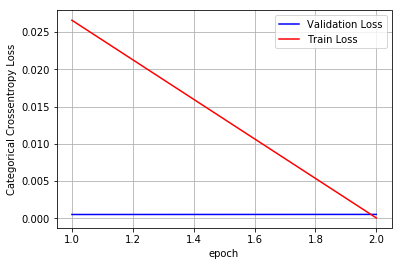

In [0]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Single LSTM layer architecture with batch size 256

In [0]:
# create the model with batch size of 256
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=256, validation_data=(X_test, Y_test), callbacks=[es])

print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 47s 514us/step - loss: 0.0895 - acc: 0.9926 - val_loss: 0.0022 - val_acc: 0.9991
Epoch 2/50
91200/91200 [==============================] - 46s 508us/step - loss: 8.5772e-04 - acc: 0.9998 - val_loss: 9.1886e-04 - val_acc: 0.9999
Epoch 3/50
91200/91200 [==============================] - 46s 507us/step - loss: 2.1468e-04 - acc: 1.0000 - val_loss: 8.8855e-04 - val_acc: 0.9999
Epoch 4/50
91200/91200 [==============================] - 47s 512us/step - loss: 9.9690e-05 - acc: 1.0000 - val_loss: 7.1318e-04 - val_acc: 1.0000
Epoch 5/50
91200/91200 [==============================] - 47s 516us/step - loss: 5.7979e-05 - acc: 1.0000 - val_loss: 6.4638e-04 - val_acc: 1.0000
Epoch 6/50
91200/91200 [==============================] - 47s 518us/step - loss: 3.7768e-05 - acc: 1.0000 - val_loss: 5.9417e-04 - val_acc: 1.0000
Epoch 7/50
91200/91200 [==============================] - 48s 521us/step - l

Test score: 0.0006232691669426633
Test accuracy: 99.99561403508773


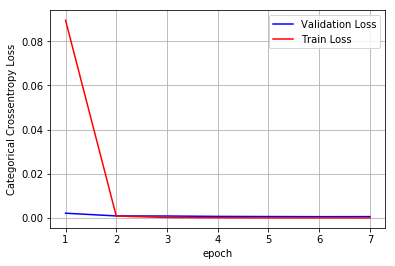

In [0]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Single LSTM layer architecture with batch size 1024

In [0]:
# create the model with batch size of 1024
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=1024, validation_data=(X_test, Y_test), callbacks=[es])
model.save('LSTM_AFR_v1.h5')
print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 26s 287us/step - loss: 0.3737 - acc: 0.9585 - val_loss: 0.0102 - val_acc: 0.9991
Epoch 2/50
91200/91200 [==============================] - 23s 258us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 3/50
91200/91200 [==============================] - 23s 248us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 4/50
91200/91200 [==============================] - 25s 275us/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0032 - val_acc: 0.9991
Epoch 5/50
91200/91200 [==============================] - 23s 249us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0024 - val_acc: 0.9991
Epoch 6/50
91200/91200 [==============================] - 23s 249us/step - loss: 8.6729e-04 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 0.9991
Epoch 7/50
91200/91200 [==============================] - 23s 251us/step - loss: 5.8328e-04 - acc: 1.0000 - val_

Test score: 0.0016192961627159988
Test accuracy: 99.92105263157895


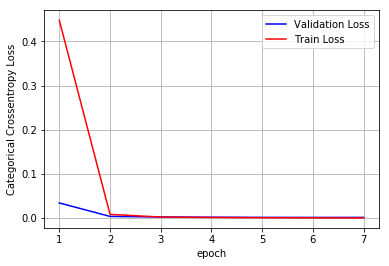

In [0]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

##  LSTM layer with relu activation

In [0]:
# create the model with batch size of 256
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, activation='relu'))
# model.add(Dropout(0.5))
# model.add(LSTM(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=1024, validation_data=(X_test, Y_test), callbacks=[es])

print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 17s 188us/step - loss: 5.6883 - acc: 0.5829 - val_loss: 7.8635 - val_acc: 0.5068
Epoch 2/50
91200/91200 [==============================] - 16s 174us/step - loss: 7.9981 - acc: 0.4983 - val_loss: 7.8635 - val_acc: 0.5068
Epoch 00002: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 115, 32)           320000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


Test score: 7.863511811975847
Test accuracy: 50.675438596491226


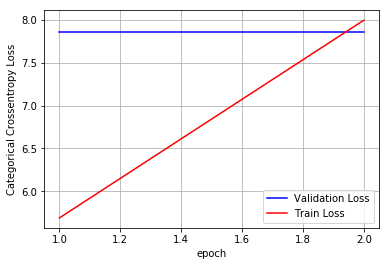

In [0]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## 2 LSTM layers architecture

In [0]:
# create the model with batch size of 256
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, input_shape=(912000, 115), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100, input_shape=(912000, 115)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=1024, validation_data=(X_test, Y_test), callbacks=[es])

print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 37s 408us/step - loss: 0.3680 - acc: 0.8664 - val_loss: 0.0074 - val_acc: 0.9989
Epoch 2/50
91200/91200 [==============================] - 35s 383us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0034 - val_acc: 0.9992
Epoch 3/50
91200/91200 [==============================] - 35s 385us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0025 - val_acc: 0.9997
Epoch 4/50
91200/91200 [==============================] - 35s 386us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0028 - val_acc: 0.9996
Epoch 00004: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 115, 32)           320000    
_________________________________________________________________
lstm_29 (LSTM)               (None, 115, 100)          53200     
____________________________________

Test score: 0.0027767170279025376
Test accuracy: 99.96052631578948


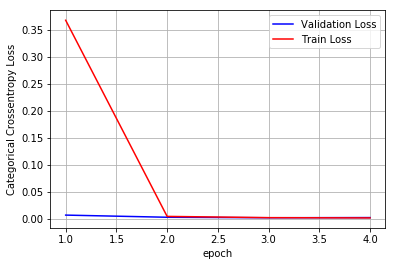

In [0]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = [' LSTM Layers','Batchsize', 'Activation', 'Dropout', "Train Accuracy", 'Test Accuracy']
x.add_row(['1', '64', "atanh", 'N','100.0','100.0'])
x.add_row(['1', '256', "atanh", "N", '100.0','100.0'])
x.add_row(['1', '1024',"atanh", "N", '100.0','99.92'])
x.add_row(['1', '1024', "relu", "N", '49.83','50.68'])
x.add_row(['2', "1024","atanh",'Y', '99.98','99.96'])
print(x)

+--------------+-----------+------------+---------+----------------+---------------+
|  LSTM Layers | Batchsize | Activation | Dropout | Train Accuracy | Test Accuracy |
+--------------+-----------+------------+---------+----------------+---------------+
|      1       |     64    |   atanh    |    N    |     100.0      |     100.0     |
|      1       |    256    |   atanh    |    N    |     100.0      |     100.0     |
|      1       |    1024   |   atanh    |    N    |     100.0      |     99.92     |
|      1       |    1024   |    relu    |    N    |     49.83      |     50.68     |
|      2       |    1024   |   atanh    |    Y    |     99.98      |     99.96     |
+--------------+-----------+------------+---------+----------------+---------------+


# Conclusions:

- Used total of 114,000 reviews from AFR dataset for this exercise.
- Balanced the dataset by taking 57k positive and 57K negative reviews.
- Converted AFR data into IMDB dataset format.
- Used index values of words to encode reviews into vectors.
- With single layer of accuarcy I am getting 100% accuracy.
- atanh activation performs better then relu in this case.
- Used return_sequences=True for 2 layers of LSTM.